# Stabilizer code tutorial
This examples goes over quantum error correction using stabilizer code.

Useful references include:
* Stabilizer Codes and Quantum Error Correction by Daniel Gottesman (https://thesis.library.caltech.edu/2900/2/THESIS.pdf) and its errata (https://www2.perimeterinstitute.ca/personal/dgottesman/thesis-errata.html)
* Stabilizer code report (https://cs269q.stanford.edu/projects2019/stabilizer_code_report_Y.pdf)
* Quantum Computing, a Gentle Introduction by Eleanor G. Rieffel and Wolfgang H. Polak. In particular chapter 11.

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq
    
from cirq.contrib.svg import SVGCircuit
import examples.stabilizer_code as sc

First, let's look at a simple repetition code. We simply encode a single qubit by repeating it three times. The construction is beyond the scope of this tutorial and a good introduction can be found in chapter 11 of the book above.

As described in section 11.1.1, the code can only correct bit flip errors (i.e. Pauli X) but cannot correct phase errors (i.e. Pauli Z). Let's build the code and look at the circuit that is generated.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


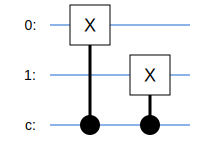

In [2]:
code = sc.StabilizerCode(group_generators=['ZZI', 'ZIZ'], correctable_errors=['X'])

additional_qubits = [cirq.NamedQubit(str(i)) for i in range(code.n - code.k)]
unencoded_qubits = [cirq.NamedQubit('c')]
qubits = additional_qubits + unencoded_qubits

circuit = code.encode(additional_qubits, unencoded_qubits)

SVGCircuit(circuit)

We see a circuit that encodes a single qubit into three qubits with the same values. These are the code words. Let's double check that we are indeed getting a repetion code. 

In [3]:
for initial_state in [0, 1]:
    results = cirq.Simulator().simulate(circuit, qubit_order=qubits, initial_state=initial_state)
    print('%d becomes %s' % (initial_state, cirq.dirac_notation(results.state_vector())))
    
    

0 becomes |000⟩
1 becomes |111⟩


You can also see that both code words commute with the generators 'ZZI' and 'ZIZ'. In other words, this is the definition of a stabilizer.

Now, we will perturb the circuit by flipping only one qubit (let's say the middle one). We will then add a circuit that computes the syndrome and performs the correction. To do this, we need to have ancillas. We then look at the output of the circuit.

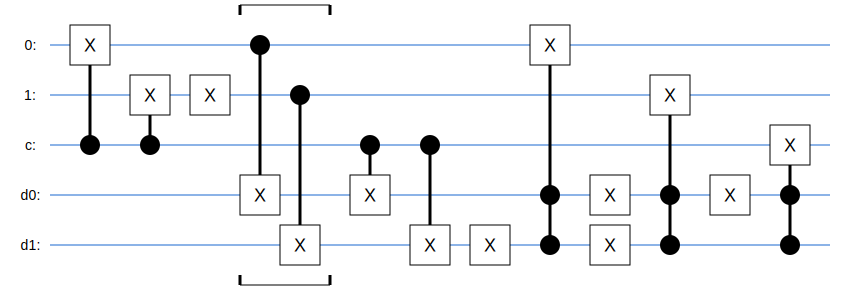

In [4]:
# Append an error:
circuit.append(cirq.X(qubits[1]))

# Correct the error:
ancillas = [cirq.NamedQubit(f"d{i}") for i in range(code.n - code.k)]
circuit += code.correct(qubits, ancillas)

SVGCircuit(circuit)

In [5]:
results = cirq.Simulator().simulate(circuit, qubit_order=(qubits+ancillas), initial_state=0)
print('%s' % (cirq.dirac_notation(results.state_vector())))

|00001⟩


You can see now 5 qubits. The first 3 qubits are the code word and the last 2 qubits are the syndrome. You can see that we have recovered the code words |000> and the syndrome is |01> resulting in a total state being |00001>. You can verify that the code works as expected. For example:
* If there is no error, the syndrome should be |00>
* Regardless of the input value, the syndrome should be the same for a given error
* You can have a linear combination of error on the same qubit, as described in section 11.2.9

We can also check that the syndrome is as predicted by the code given the errors.

In [6]:
code.syndromes_to_corrections

{(-1, 1): ('X', 0), (1, -1): ('X', 1), (-1, -1): ('X', 2)}

Finally, we can decode the output by using a Pauli string measurement.

In [7]:
decoded = code.decode(qubits, ancillas, results.state_vector())
print('decoded=%s' % (decoded))

decoded=[0]


Finally, let's look at a more complicated code, the five-qubit code. We can verify that we get the same code words as equations 3.17 and 3.18 in the thesis. The reader can repeat the steps above to check that the syndrome is computed correctly and that the errors can be corrected. The unit tests do check these properties.

In [8]:
code = sc.StabilizerCode(group_generators=['XZZXI', 'IXZZX', 'XIXZZ', 'ZXIXZ'], correctable_errors=['X', 'Z'])

additional_qubits = [cirq.NamedQubit(str(i)) for i in range(code.n - code.k)]
unencoded_qubits = [cirq.NamedQubit('c')]
qubits = additional_qubits + unencoded_qubits

circuit = code.encode(additional_qubits, unencoded_qubits)

for initial_state in [0, 1]:
    results = cirq.Simulator().simulate(circuit, qubit_order=qubits, initial_state=initial_state)
    print('%d becomes:\n %s\n' % (initial_state, cirq.dirac_notation(4.0 * results.state_vector())))

0 becomes:
 |00000⟩ - 1|00011⟩ + |00101⟩ - 1|00110⟩ + |01001⟩ + |01010⟩ - 1|01100⟩ - 1|01111⟩ - 1|10001⟩ + |10010⟩ + |10100⟩ - 1|10111⟩ - 1|11000⟩ - 1|11011⟩ - 1|11101⟩ - 1|11110⟩

1 becomes:
 |00001⟩ + |00010⟩ + |00100⟩ + |00111⟩ + |01000⟩ - 1|01011⟩ - 1|01101⟩ + |01110⟩ + |10000⟩ + |10011⟩ - 1|10101⟩ - 1|10110⟩ + |11001⟩ - 1|11010⟩ + |11100⟩ - 1|11111⟩

